In [18]:
import pandas as pd
import datetime
import shapely
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from IPython.display import Image
from shapely.ops import transform, cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

## We import the data

In [57]:
stations=pd.read_csv('../data/geo_spatial/dienststellen-gemass-opentransportdataswiss.csv', sep=';')
main_stations=pd.read_csv('../data/scrapped_data/main_stations_scrapper.csv')
swiss_post_points = pd.read_csv('../data/geo_spatial/zugangspunkte-post.csv', sep=';')
#dropping nans 
swiss_post_points = swiss_post_points[swiss_post_points.geopoint.notna()]
swiss_boundary = gpd.read_file('../data/Switzerland_shapefile/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')

/Users/nicolasfelipevergaraduran/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (20,21,22,23,24,31,33,35,37) have mixed types.Specify dtype option on import or set low_memory=False.



## Now we filter the points that are main stations

In [3]:
def erase_last_digit(int_):
    if int_>9:
        list_ints=[a for a in str(int_)[:-1]]
        joined_str=''.join(list_ints)
        return int(joined_str)
    else:
        return int_
def take_first_name(name):
    if 'Limmattal' in name:
        return 'Limmattal'
    elif '/' in name: 
        return name.split('/')[0]
    elif '-' in name: 
        return name.split('-')[0]
    elif ' ' in name: 
        return name.split(' ')[0]
    elif 'Genève' in name:
        return 'Genf'
    else:
        return name

In [4]:
#defining filtering criteria based on scraped data 
keys1=['Content-Type: text/plain; charset=utf-8\n','Short_name']
keys2=['Short_id','Short_name']
main_stations['Short_id']=main_stations.Station_id.map(erase_last_digit)
main_stations['Short_name']=main_stations.Name.map(take_first_name)
stations['Short_name']=stations['Stop name'].map(take_first_name)

i1 = stations.set_index(keys1).index
i2 = main_stations.set_index(keys2).index

In [61]:
#we take only the stations that are service points for freight.
service_points=stations[i1.isin(i2)].loc[(stations[i1.isin(i2)].IS_BEDIENPUNKT==1) & (stations[i1.isin(i2)]['CANTON NAME'].notna())]
service_points['latitude']=service_points.Geopos.str.split(',').map(lambda x: float(x[0]))
service_points['longitude']=service_points.Geopos.str.split(',').map(lambda x: float(x[1]))
geo_service_points = gpd.GeoDataFrame(service_points, geometry=gpd.points_from_xy(service_points.longitude,
                                                                                  service_points.latitude))
#we filter the points for swiss post 
swiss_post_points.geopoint
swiss_post_points['latitude']=swiss_post_points.geopoint.str.split(',').map(lambda x: float(x[0]))
swiss_post_points['longitude']=swiss_post_points.geopoint.str.split(',').map(lambda x: float(x[1]))
geo_swisspost_points = gpd.GeoDataFrame(swiss_post_points, geometry=gpd.points_from_xy(swiss_post_points.longitude,
                                                                                  swiss_post_points.latitude))

## We transform the points from the swiss LV95 projection into the World Geodetic System 

In [6]:
lv95 = pyproj.CRS('EPSG:2056')
wgs84 = pyproj.CRS('EPSG:4326')
project = pyproj.Transformer.from_crs(lv95, wgs84, 
                                          always_xy=True).transform
swiss_boundary['geometry']=swiss_boundary.geometry.map(lambda x: transform(project, x))

## We display the computed service stations

In [7]:
fig=px.scatter_geo(service_points, lat="latitude",lon='longitude',color="CANTON NAME",
                     hover_name="Stop name",scope='europe')

fig.show()

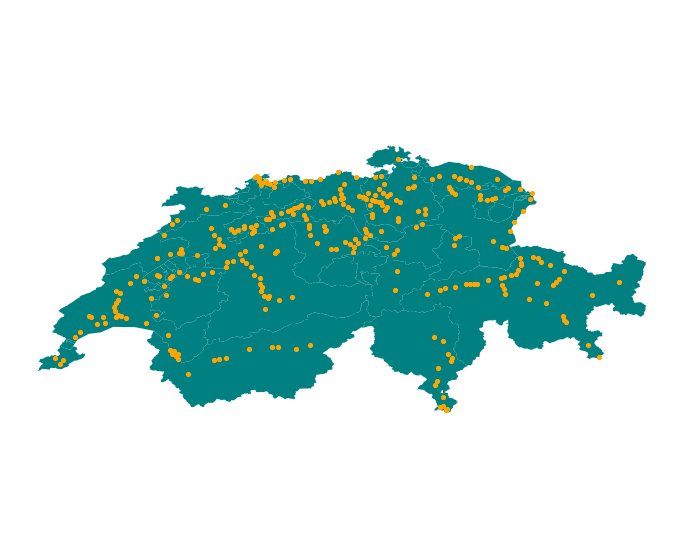

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
swiss_boundary.plot(ax=ax, color='teal')
geo_service_points.plot(ax=ax, markersize=17.5, color='orange')
ax.axis('off')
plt.axis('equal')
plt.show()

## Then, we have recovered only the stations in the main freight roads
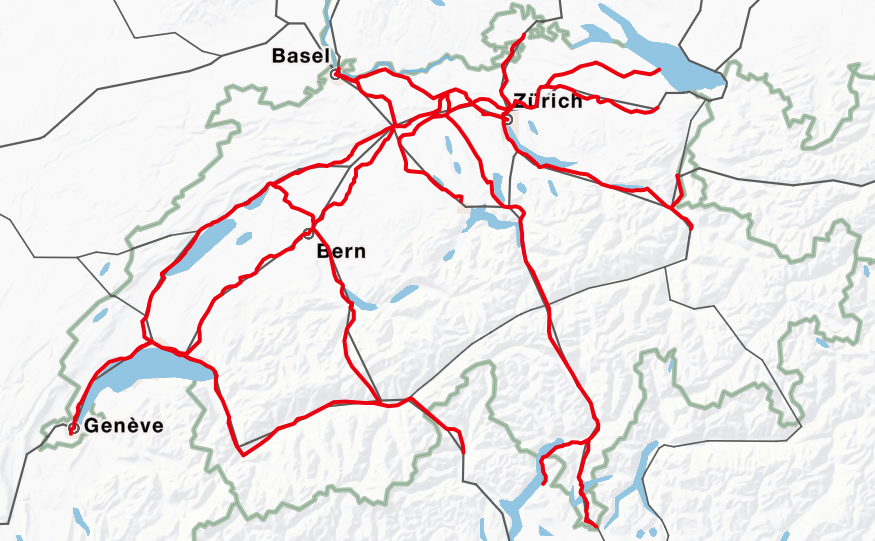

## We concatenate all kantons into one single boundary

In [9]:
entire_swiss_shape=cascaded_union(swiss_boundary.geometry)
voronoi_centers = points_to_coords(geo_service_points.geometry)

### Now we compute the Voronoi Regions 

In [10]:
# Calculate Voronoi Regions
poly_shapes, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_centers, entire_swiss_shape)

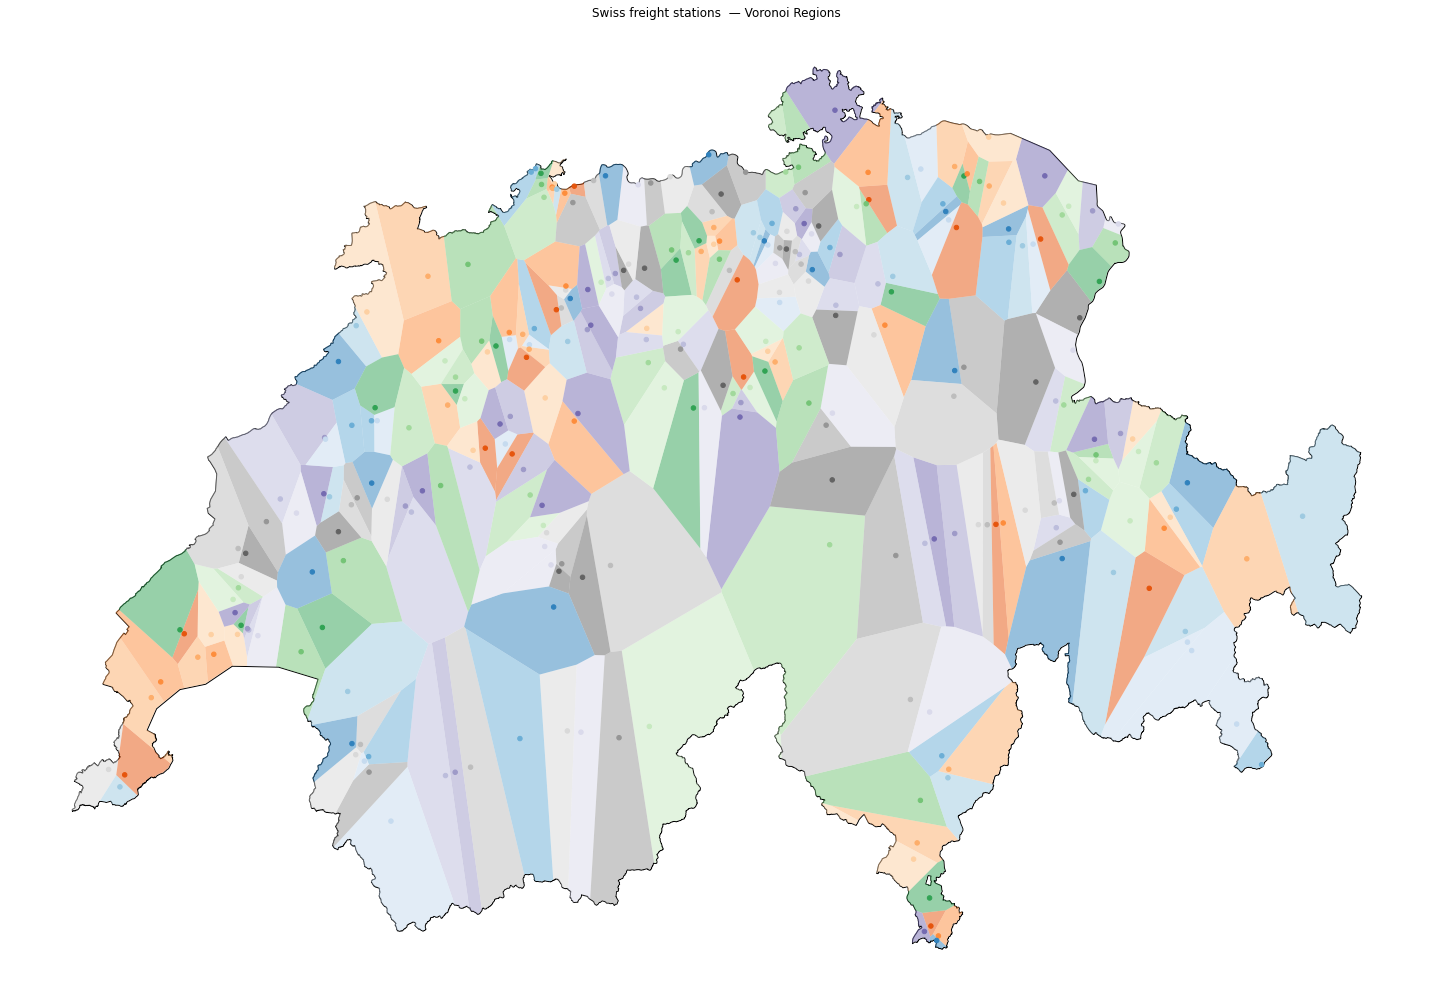

In [64]:
#now we plot them 
fig, ax = plt.subplots(figsize=(20,14))
plot_voronoi_polys_with_points_in_area(ax, entire_swiss_shape, poly_shapes,voronoi_centers, poly_to_pt_assignments,
 voronoi_and_points_cmap='tab20c',
 points_markersize=20)
ax.set_title('Swiss freight stations  — Voronoi Regions')
ax.axis('off')
plt.tight_layout()
plt.show()

## Next we check with respecto to the other points

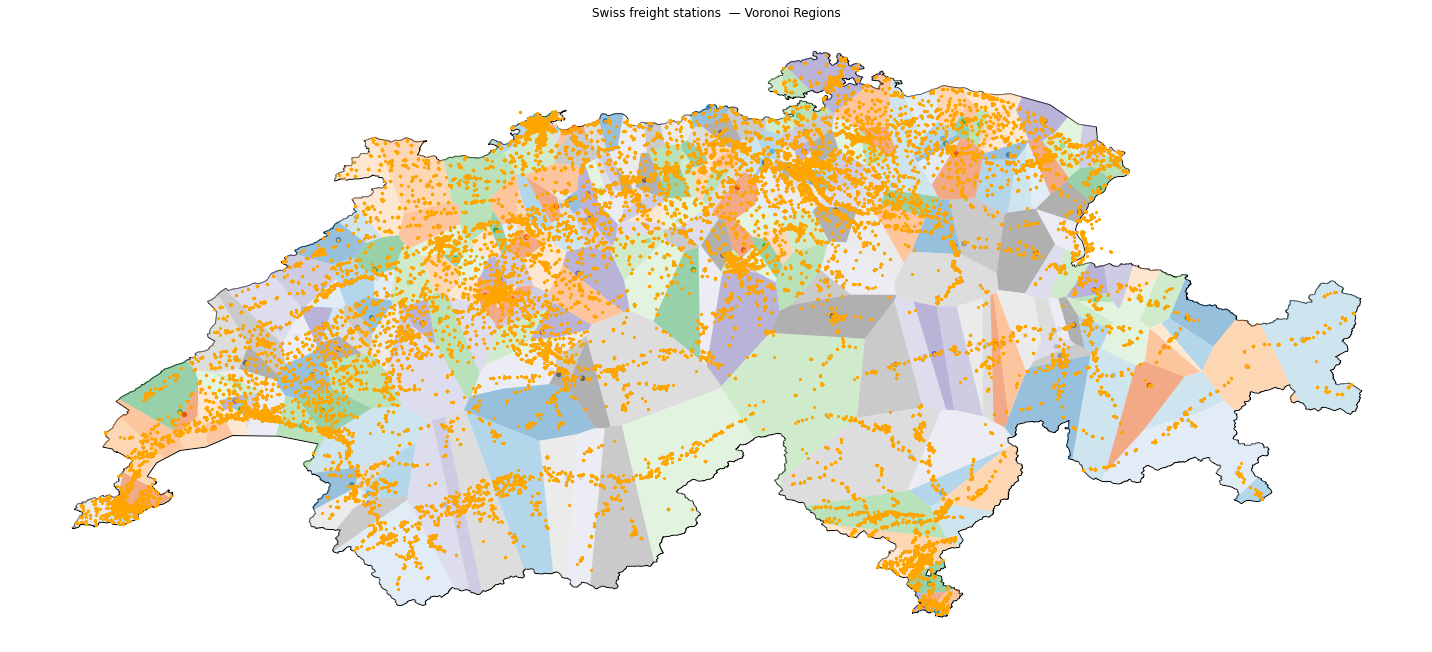

In [65]:
#now we plot them 
fig, ax = plt.subplots(figsize=(20,14))
plot_voronoi_polys_with_points_in_area(ax, entire_swiss_shape, poly_shapes,voronoi_centers, poly_to_pt_assignments,
 voronoi_and_points_cmap='tab20c',
 points_markersize=20)
geo_swisspost_points.plot(ax=ax, markersize=4.5, color='orange')
ax.set_title('Swiss freight stations  — Voronoi Regions')
ax.axis('off')
plt.tight_layout()
plt.show()

0        2
1        2
2        2
3        2
4        2
        ..
89848    2
89849    2
89850    2
89851    2
89852    2
Name: geopoint, Length: 89842, dtype: int64